In [7]:
"""
provide functions for working with and visualizing scalar ARMA processes
"""

import numpy as np
from numpy import conj, pi
import matplotlib.pyplot as plt
from scipy.signal import dimpulse, freqz, dlsim

#==ignore unnecessary warnings concerning casting complex variables back to 
# floats==#

import warnings
warnings.filterwarnings('ignore')

class ARMA(object):
    r"""
    this class represents scalar ARMA(p, q) processes
    
    if phi and theta are scalars, then the model is
    understood to be
    
    .. math::
        
        X_t = \phi X_{t-1} + \epsilon_t + \theta \epsilon_{t-1}
        
    where :math: 'epsilon_t' is a white noise process with standard
    deviation :math: 'sigma'. If phi and theta are arrays or sequences, 
    then the interpretation is the ARMA(p, q) model
    
    .. math::
        
        X_t = \phi_1 X_{t-1} + ... + \phi_p X_{t-p} + 
        
        \epsilon_t + \theta_1 \epsilon_{t-1} + ... +
        \theta_q \epsilon_{t-q}
        
    where 
    
        * :math: '\phi = (\phi_1, \phi_2, ..., \phi_p)'
        * :math: '\theta = (\theta_1, \theta_2, ..., \theta_q)'
        * :math: '\sigma' is a scalar, the standard deviation of the
        while noise
        
    parameters
    ------
    phi: scalar or iterable or array_like(float)
        autocorrelation values for the autocorrelated variable.
        see above for explanation
    theta: scalar or iterable or array_like(float)
        autocorrelation values for the while noise of the model
        see above for explanation
    sigma: scalar(float)
        the standard deviation of the while noise
    
    attributes
    ------
    phi, theta, sigma: see parameters
    ar_poly: array_like(float)
        the polynomial form that is needed by scipy.signal to do the
        processing we desire. corresponds with the phi values.
    ma_poly: array_like(float)
        the polynomial form that is needed by scipy.signal to do the
        processing we desire. corresponds with the theta values.
        
    """
    
    def __init__(self, phi, theta=0, sigma=1):
        self._phi, self._theta = phi, theta
        self.sigma = sigma
        self.set_params()
        
    def __repr__(self):
        m = "ARMA(phi= %s, theta= %s, sigma= %s)"
        return m % (self.phi, self.theta, self.sigma)
    
    def __str__(self):
        m = "an ARMA({p}, {q}) process"
        p = np.asarray(self.phi).size
        q = np.asarray(self.theta).size
        return m.format(p=p, q=q)
    
    #special latex print method for working in notebook
    def _repr_latex_(self):
        m = r"$X_t = "
        phi = np.atleast_1d(self.phi)
        theta = np.atleast_1d(self.theta)
        rhs =""
        for (tm, phi_p) in enumerate(phi):
            #don't include terms if they are equal to zero
            if abs(phi_p) > 1e-12:
                rhs += r" %+g X_{t-%i}" %(phi_p, tm+1)
        
        if rhs[0] == "+":
            rhs = rhs[1:] #remove initial '+'  if phi_1 was positive
            
        rhs += r" + \epsilon_t"
        
        for (tm, th_q) in enumerate(theta):
            #don't include terms if they are equal to zero
            if abs(the_q) > 1e-12:
                rhs += r" %+g \epsilon_{t-%i}" %(th_q, tm+1)
                
        return m +rhs + "$"
    
    @property
    def phi(self):
        return self._phi
    
    @phi.setter
    def phi(self, new_value):
        self._phi = new_value
        self.set_params()
        
    @property
    def theta(self):
        return self._theta
    
    @theta.setter
    def theta(self, new_value):
        self._theta = new_value
        self.set_params()
        
    def set_params(self):
        r"""
        internally, scipy.signal works with systems of the form
        
        .. math::
            
            ar_{poly}(L) X_t = ma_{poly}(L) \epsilon_t
            
        where L is the lag operator. To match this, we set
        
        .. math::
        
            ar_{poly} = (1, -\phi_1, -\phi_2, ..., -\phi_p)
            
            ma_{poly} = (1, \theta_1, \theta_2, ..., \theta_q)
            
        in addition, ar_poly must be at least as long as ma_poly
        this can be achieved by padding it out with zeros when required.
        
        """
        #==set up ma_poly==#
        ma_poly = np.asarray(self._theta)
        self.ma_poly = np.insert(ma_poly, 0, 1) #the array (1, theta)
        
        #==set up ar_poly==#
        if np.isscalar(self._phi):
            ar_poly = np.array(-self._phi)
        else:
            ar_poly = -np.asarray(self._phi)
        self.ar_poly = np.insert(ar_poly, 0, 1) # the array (1, -phi)
        
        #==pad ar_poly with zeros if required==#
        if len(self.ar_poly) < len(self.ma_poly):
            temp = np.zeros(len(self.ma_poly)-len(self.ar_poly))
            self.ar_poly = np.hstack((self.ar_poly, temp))
            
    def impulse_response(self, impulse_length=30):
        """
        get the impulse response corresponding to our model.
        
        returns
        ------
        psi: array_like(float)
            psi[j] is the response at lag j of the impulse response.
            we take psi[0] as unity
            
        """
        sys = self.ma_poly, self.ar_poly, 1
        times, psi = dimpulse(sys, n=impulse_length)
        psi = psi[0].flatten() #simplify return value into flat array
        
        return psi
    
    def spectral_density(self, two_pi=True, res=1200):
        r"""
        compute the spectral density function. the spectral density is
        the discrete time Fourier transform of the autocovariance
        function. in particular, 
        
        .. math::
        
            f(w) = \sum_k \gamma(k) exp(-ikw)
            
        where gamma is the autocovariance function and the sum is over
        the set of all integers.
        
        parameters
        ------
        two_pi: Boolean, optional
            compute the spectral density function over [0, pi] if
            two_pi is False and [0, 2 pi] otherwise. Default value is
            True
        res: scalar or array_like(int), optional(default=1200)
            if res is a scalar then the spectral density is computed at
            'res' frequencies evenly spaced around the unit circle, but
            if res is an array then the function computes the response
            at the frequencies given by the array
            
        returns
        ------
        w: array_like(float)
            the normalized frequencies at which h was computed, in
            radians/sample
        spect: array_like(float)
            the frequency response
            
        """
        w, h = freqz(self.ma_poly, self.ar_poly, worN=res, whole=two_pi)
        spect = h * conj(h) * self.sigma**2
        
        return w, spect
    
    def autocovariance(self, num_autocov=16):
        """
        compute the autocovariance function from the ARMA parameters
        over the integers range(num_autocov) using the spectral density
        and the inverse Fourier transform.
        
        parameters
        ------
        num_autocov: scalar(int), optional(default=16)
            the number of autocovariances to calculate
            
        """
        spect = self.spectral_density()[1]
        acov = np.fft.ifft(spect).real
        
        #num_autocov should be <= len(acov) / 2
        return acov[:num_autocov]
    
    def simulation(self, ts_length=90):
        """
        compute a simulated sample path assuming Gaussian shocks.
        
        parameters
        ------
        ts_length: scalar(int), optional(default=90)
            number of periods to simulate for
            
        returns
        ------
        vals: array_like(float)
            a simulation of the model that corresponds to this class
            
        """
        sys = self.ma_poly, self.ar_poly, 1
        u = np.random.randn(ts_length, 1) * self.sigma
        vals = dlsim(sys, u)[1]
        
        return vals.flatten()
    
    def plot_impulse_response(self, ax=None, show=None):
        if show:
            fig, ax = plt.subplots()
        ax.set_title('Impulse response')
        yi = self.impulse_response()
        ax.stem(list(range(len(yi))), yi)
        ax.set_xlim(xmin=(-0.5))
        ax.set_ylim(min(yi)-0.1, max(yi)+0.1)
        ax.set_xlabel('time')
        ax.set_ylabel('response')
        if show:
            plt.show()
            
    def plot_spectral_density(self, ax=None, show=None):
        if show:
            fig, ax = plt.subplots()
        ax.set_title('Spectral density')
        w, spect = self.spectral_density(two_pi =False)
        ax.semilogy(w, spect)
        ax.set_xlim(0, pi)
        ax.set_ylim(0, np.max(spect))
        ax.set_xlabel('frequency')
        ax.set_ylabel('spectrum')
        if show:
            plt.show()
            
    def plot_autocovariance(self, ax=None, show=True):
        if show:
            fig, ax = plt.subplots()
        ax.set_title('Autocovariance')
        acov = self.autocovariance()
        ax.stem(list(range(len(acov))), acov)
        ax.set_xlim(-0.5, len(acov) -0.5)
        ax.set_xlabel('time')
        ax.set_ylabel('autocovariance')
        if show:
            plt.show()
            
    def plot_simulation(self, ax=None, show=None):
        if show:
            fig, ax = plt.subplots()
        ax.set_title('Sample path')
        x_out = self.simulation()
        ax.plot(x_out)
        ax.set_xlabel('time')
        ax.set_ylabel('state space')
        if show:
            plt.show()
            
    def quad_plot(self):
        """
        plots the impulse response, spectral_density, autocovariance, 
        and one realization of the process.
        
        """
        num_rows, num_cols =2, 2
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
        plt.subplots_adjust(hspace=0.4)
        plot_functions =[self.plot_impulse_response,
                        self.plot_spectral_density,
                        self.plot_autocovariance,
                        self.plot_simulation]
        for plot_func, ax in zip(plot_functions, axes.flatten()):
            plot_func(ax, show=False)
        plt.show()

In [8]:
phi=0.5
theta=0, -0.8
lp=ARMA(phi, theta)

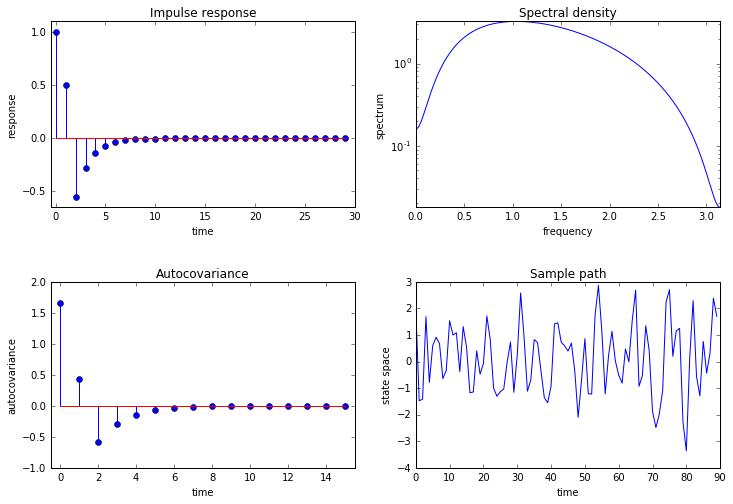

In [9]:
%matplotlib inline
lp.quad_plot()